# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Данные геологоразведки трёх регионов:**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

**Цель данной работы** - Построить модель, способную определить наиболее доходных регион добычи нефти.

**Работа пройдет в следующие 5 этапов:**
1. Загрузка и подготовка данных;
2. Обучение и проверка моделей;
3. Подготовка к расчёту прибыли;
4. Расчёт потенциальной прибыли;
5. Расчёт рисков.

## Используемые библиотеки и функции

### Библиотеки

In [1]:
# Data tools
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Data structure
from sklearn.model_selection import train_test_split

# ML
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Bootstrap
from scipy import stats as st
from numpy.random import RandomState
state = RandomState(42)

# Files paths
import os

# Global settings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 100)
pd.options.display.max_colwidth = 75

sns.set_theme(style="whitegrid")

# Const
RANDOM_STATE = 42

### Функции

In [2]:
def create_scan(df, asc=False):
    unique_values = []
    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique())  # asc

    table_scan = pd.DataFrame(
        {
            'values_num': df.count(),
            'nan_values_num': df.isna().sum(),
            'occupancy': 100 - (df.isna().sum() / (df.isna().sum() + df.notna().sum()) * 100),
            'unique_values_num': df.nunique(),
            'min_value': df.min(),
            'max_value': df.max(),
            'unique_values': unique_values,
            'dtype': df.dtypes
        }
    )

    print(f'Duplicates in the table: {df.duplicated().sum()}, {round(df.duplicated().sum() / df.shape[0], 2)}%')
    print()

    return table_scan


def data_visualization(ds, drop_columns):
    for i in ds.drop(drop_columns, axis=1):
        print('-----------------------------------------------------------------------------------------------------')
        if i == 'product':
            print('Target:')
        else:
            print(i)

        figure, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},
                                                 figsize=(12, 5))

        sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

        sns.boxplot(ds[i], ax=ax_box).set_title(f'{i}', y=1.5, fontsize=14)
        sns.histplot(ds[i], bins=50, kde=True, ax=ax_hist)

        plt.show()

        display(ds[i].describe())


def correlation(ds, drop_columns, pair_plots, method='pearson'):
    if pair_plots:
        cor_ds = ds.drop(columns=drop_columns).corr(method=method)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cor_ds, vmin=-1, vmax=1, center=0, linewidths=3, linecolor='white', annot=True, cmap='coolwarm')
        sns.pairplot(ds.drop('id', axis=1))

        plt.show()
    else:
        cor_ds = ds.drop(columns=drop_columns).corr(method=method)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cor_ds, vmin=-1, vmax=1, center=0, linewidths=3, linecolor='white', annot=True, cmap='coolwarm')

        plt.show()


def pred_statistics(data_0, data_1, data_2):
    statistics = pd.Series(data_0).describe().reset_index().merge(
        pd.Series(data_1).describe().reset_index().merge(
            pd.Series(data_2).describe().reset_index(), on='index'
        ), on='index'
    ).rename(
        columns={
            'index': 'statistics',
            0: 'predictions_0',
            '0_x': 'predictions_1',
            '0_y': 'predictions_2',
        }
    )

    print('Predictions statistics analysis:')
    return statistics


def predictions_visualization(data_0, data_1, data_2, negative_values=False):
    print('Predictions visualization:')

    ds_0 = pd.DataFrame(data_0).rename(columns={0: 'predictions_0'})
    ds_1 = pd.DataFrame(data_1).rename(columns={0: 'predictions_1'})
    ds_2 = pd.DataFrame(data_2).rename(columns={0: 'predictions_2'})

    if negative_values:
        figure, axes = plt.subplots(2, 3, figsize=(20, 8))

        sns.boxplot(ds_0.query('predictions_0 < 0')['predictions_0'], ax=axes[0, 0]).set_title(
            'pred_0. Negative values', y=1, fontsize=12)
        sns.boxplot(ds_1.query('predictions_1 < 0')['predictions_1'], ax=axes[0, 1]).set_title(
            'pred_1. Negative values', y=1, fontsize=12)
        sns.boxplot(ds_2.query('predictions_2 < 0')['predictions_2'], ax=axes[0, 2]).set_title(
            'pred_2. Negative values', y=1, fontsize=12)

        sns.histplot(ds_0, bins=50, kde=True, ax=axes[1, 0])
        sns.histplot(ds_1, bins=50, kde=True, ax=axes[1, 1])
        sns.histplot(ds_2, bins=50, kde=True, ax=axes[1, 2])

        plt.show()
    else:
        figure, axes = plt.subplots(1, 3, figsize=(20, 5))

        sns.histplot(ds_0, bins=50, kde=True, ax=axes[0])
        sns.histplot(ds_1, bins=50, kde=True, ax=axes[1])
        sns.histplot(ds_2, bins=50, kde=True, ax=axes[2])

        plt.show()


def revenue(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]

    return round(450 * selected.sum(), 2)


def bootstrap_profit(est, target, target_n, state, pred):
    values = []
    for i in range(est):
        target_subsample = target.sample(n=target_n, replace=True, random_state=state)
        pred_subsample = pred[target_subsample.index]

        values.append(revenue(target_subsample, pred_subsample, DEVELOPMENT_WELLS) - BUDGET)

    return pd.Series(values)

## Загрузка и подготовка данных

Для построения целевых моделей нам необходимо загрузить данные и сформировать датасеты для каждого региона, определив параметры `features` и целевые признаки `target`.

Для это последовательно выполним следующие шаги:
1. Загрузим данные и проведем их верхнеуровневый анализ;
2. Визуализируем данные;
3. Расчитаем корреляции данных;
4. Вычислим статистики данных;
5. Определим независимые признаки `features` и целевой признак `target` для каждого региона;
6. Сформируем обучающие и валидационные выборки для каждого региона;
7. Проведем препоцессинг `features`.

### Загрузка и верхнеуровневый анализ данных

In [3]:
data_pth0_1 = 'geo_data_0.csv'
data_pth0_2 = '/datasets/geo_data_0.csv'

if os.path.exists(data_pth0_1):
    geo_data_0 = pd.read_csv(data_pth0_1)
elif os.path.exists(data_pth0_2):
    geo_data_0 = pd.read_csv(data_pth0_2)
else:
    print('Ошибка!')
    
data_pth1_1 = 'geo_data_1.csv'
data_pth1_2 = '/datasets/geo_data_1.csv'

if os.path.exists(data_pth1_1):
    geo_data_1 = pd.read_csv(data_pth1_1)
elif os.path.exists(data_pth1_2):
    geo_data_1 = pd.read_csv(data_pth1_2)
else:
    print('Ошибка!')
    
data_pth2_1 = 'geo_data_2.csv'
data_pth2_2 = '/datasets/geo_data_2.csv'

if os.path.exists(data_pth2_1):
    geo_data_2 = pd.read_csv(data_pth2_1)
elif os.path.exists(data_pth2_2):
    geo_data_2 = pd.read_csv(data_pth2_2)
else:
    print('Ошибка!')

#### Регион 0

In [4]:
print('geo_data_0')
display(geo_data_0.head())
create_scan(geo_data_0)

geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Duplicates in the table: 0, 0.0%



,values_num,nan_values_num,occupancy,unique_values_num,min_value,max_value,unique_values,dtype
id,100000,0,100.0,99990,006OJ,zzzLH,"[zzzLH, zzyhQ, zztWK, zzsy6, zzrmI, zzqJM, zzmft, zzivF, zziDs, zzaKq, ...",object
f0,100000,0,100.0,100000,-1.408605,2.362331,"[2.362330810854224, 2.3370795675225464, 2.3337526924465672, 2.308939052...",float64
f1,100000,0,100.0,100000,-0.848218,1.343769,"[1.343769333804496, 1.3348276216963582, 1.3333456053179722, 1.331252858...",float64
f2,100000,0,100.0,100000,-12.088328,16.00379,"[16.003790007695365, 15.428371873680216, 15.230321587067742, 15.2028383...",float64
product,100000,0,100.0,100000,0.0,185.364347,"[185.3643474222929, 185.3626902521712, 185.35561503190544, 185.35498029...",float64


#### Регион 1

In [5]:
print('geo_data_1')
display(geo_data_1.head())
create_scan(geo_data_1)

geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Duplicates in the table: 0, 0.0%



,values_num,nan_values_num,occupancy,unique_values_num,min_value,max_value,unique_values,dtype
id,100000,0,100.0,99996,0022J,zzzvI,"[zzzvI, zzy2c, zzv4E, zzuxl, zzstP, zzrV0, zzr4l, zzqYC, zzoZe, zzoKi, ...",object
f0,100000,0,100.0,100000,-31.609576,29.421755,"[29.42175461390372, 29.25906207789393, 28.930828787727965, 28.400991653...",float64
f1,100000,0,100.0,100000,-26.358598,18.734063,"[18.73406263373076, 16.737196196172107, 16.026869298646595, 15.96515129...",float64
f2,100000,0,100.0,100000,-0.018144,5.019721,"[5.019720555223062, 5.019091417811521, 5.017503445815132, 5.01680354240...",float64
product,100000,0,100.0,12,0.0,137.945408,"[137.94540774090564, 134.76630515769844, 110.992146709366, 107.81304412...",float64


#### Регион 2

In [6]:
print('geo_data_2')
display(geo_data_2.head())
create_scan(geo_data_2)

geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Duplicates in the table: 0, 0.0%



,values_num,nan_values_num,occupancy,unique_values_num,min_value,max_value,unique_values,dtype
id,100000,0,100.0,99996,009Gl,zzz9h,"[zzz9h, zzsKd, zzqqy, zzpit, zzp3z, zzoNY, zznk3, zzkjZ, zzjyH, zzjcP, ...",object
f0,100000,0,100.0,100000,-8.760004,7.238262,"[7.23826247979405, 7.21552716578695, 7.194614853677338, 7.1591688181107...",float64
f1,100000,0,100.0,100000,-7.08402,7.844801,"[7.844801270084258, 7.761857138663879, 7.101618418422805, 7.08062048572...",float64
f2,100000,0,100.0,100000,-11.970335,16.739402,"[16.73940205869952, 16.35764509040699, 16.313011220972406, 16.252444439...",float64
product,100000,0,100.0,100000,0.0,190.029838,"[190.0298383433513, 190.01358899804384, 190.01172239678743, 190.0109816...",float64


### Визуализация данных

#### Регион 0

-----------------------------------------------------------------------------------------------------
f0


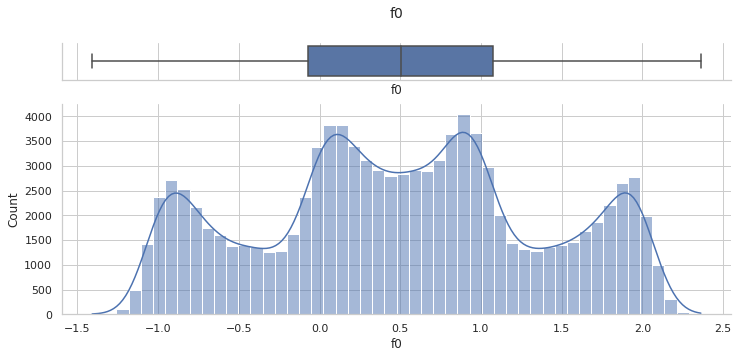

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

-----------------------------------------------------------------------------------------------------
f1


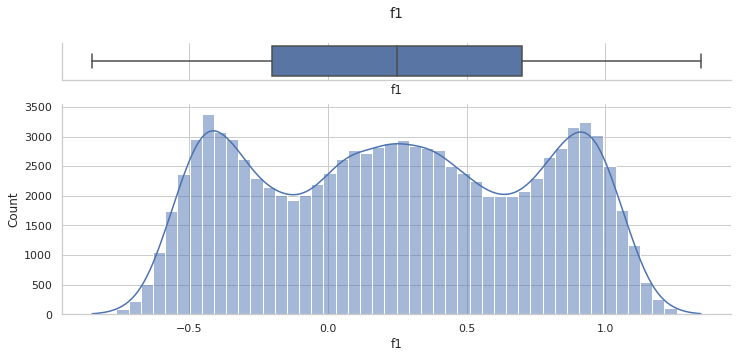

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

-----------------------------------------------------------------------------------------------------
f2


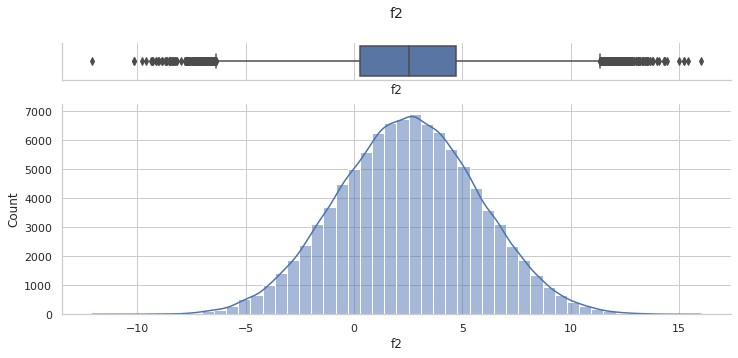

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

-----------------------------------------------------------------------------------------------------
Target:


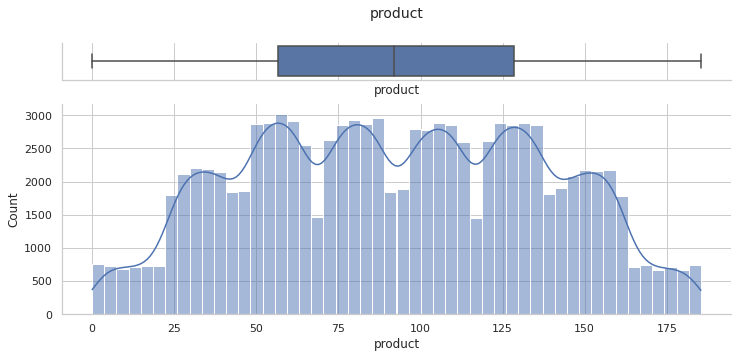

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

In [7]:
data_visualization(geo_data_0, 'id')

#### Регион 1

-----------------------------------------------------------------------------------------------------
f0


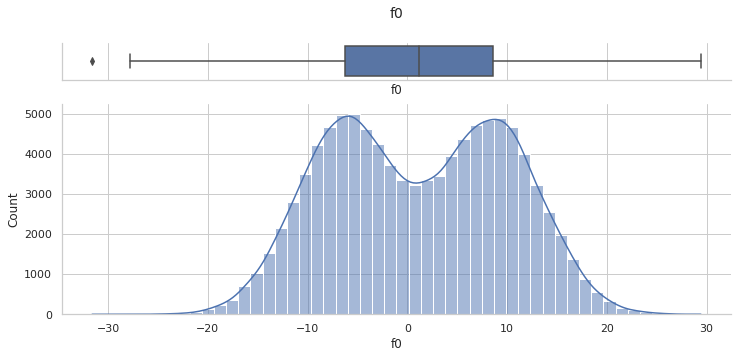

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64

-----------------------------------------------------------------------------------------------------
f1


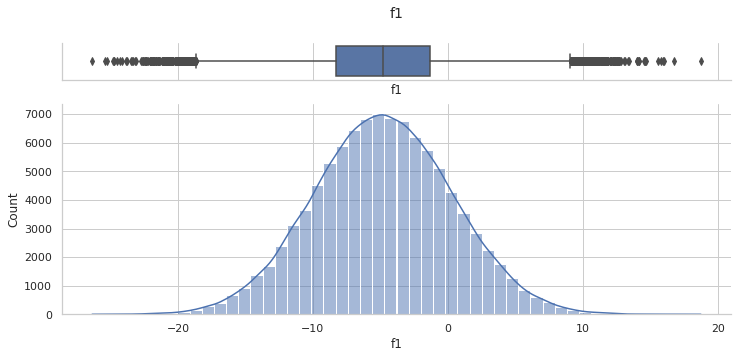

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64

-----------------------------------------------------------------------------------------------------
f2


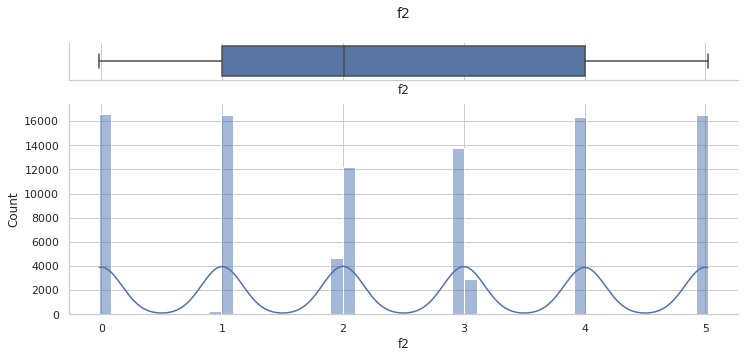

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64

-----------------------------------------------------------------------------------------------------
Target:


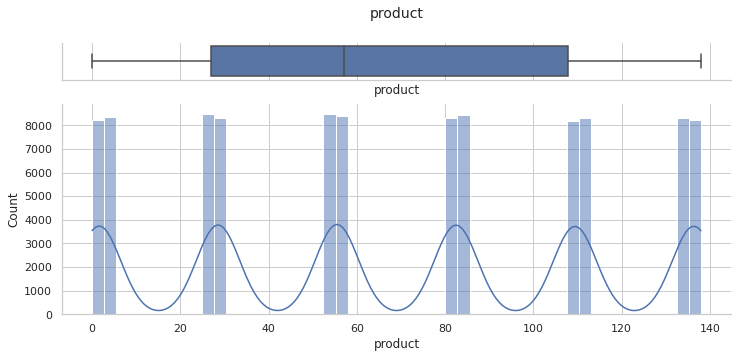

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [8]:
data_visualization(geo_data_1, 'id')

#### Регион 2

-----------------------------------------------------------------------------------------------------
f0


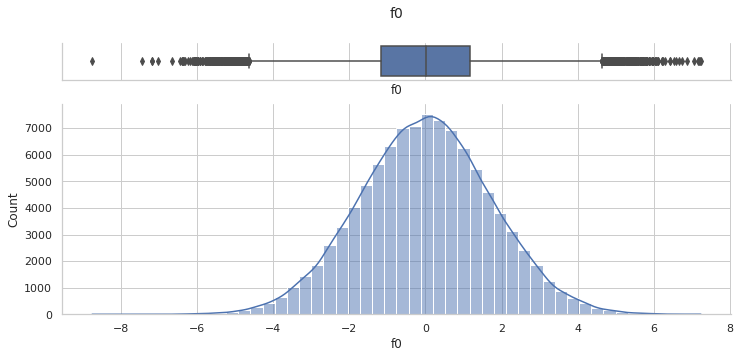

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64

-----------------------------------------------------------------------------------------------------
f1


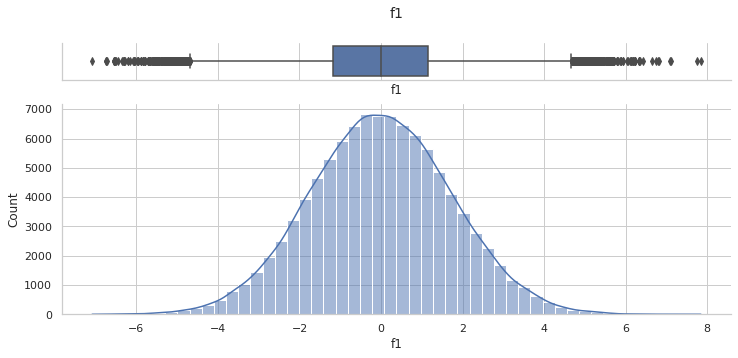

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64

-----------------------------------------------------------------------------------------------------
f2


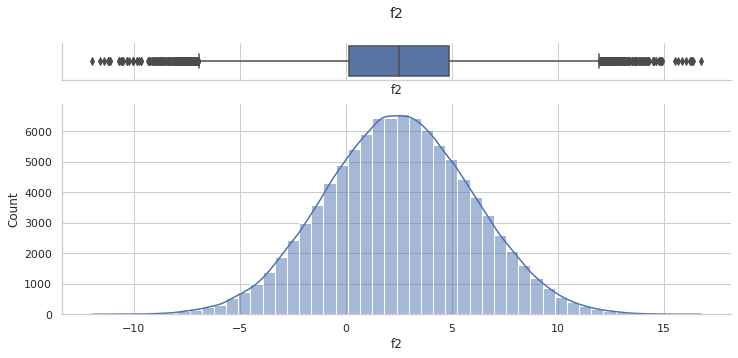

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64

-----------------------------------------------------------------------------------------------------
Target:


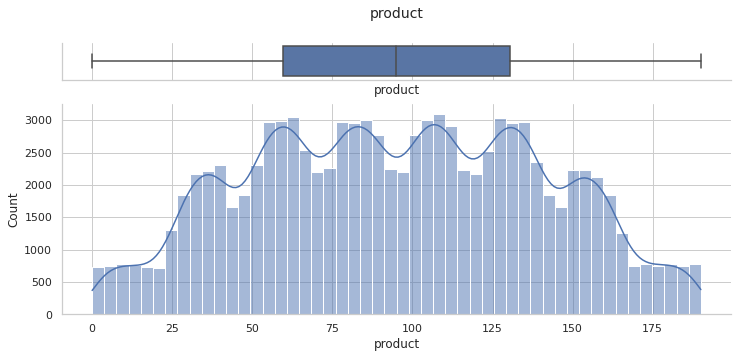

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

In [9]:
data_visualization(geo_data_2, 'id')

**Можно сделать следующие выводы:**
- Данные распределены, в основном, ненормально;
- Распределение данных у региона 1 сильно отличается от других регионов.

Учтем это при препроцессинге `features` и построении моделей.

### Расчет корреляций

#### Регион 0

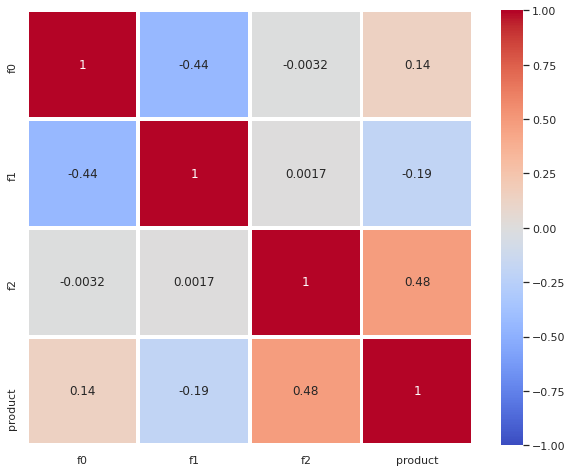

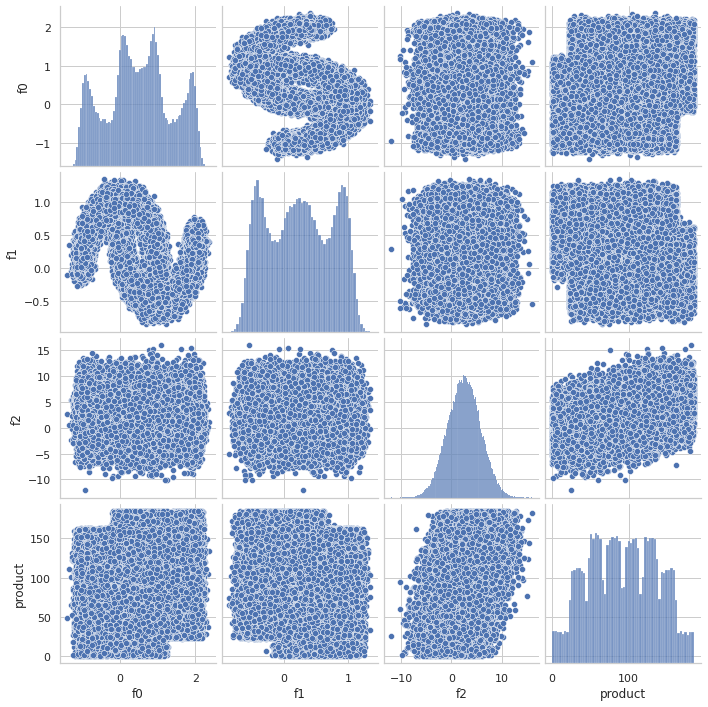

In [10]:
correlation(geo_data_0, 'id', pair_plots=True)

#### Регион 1

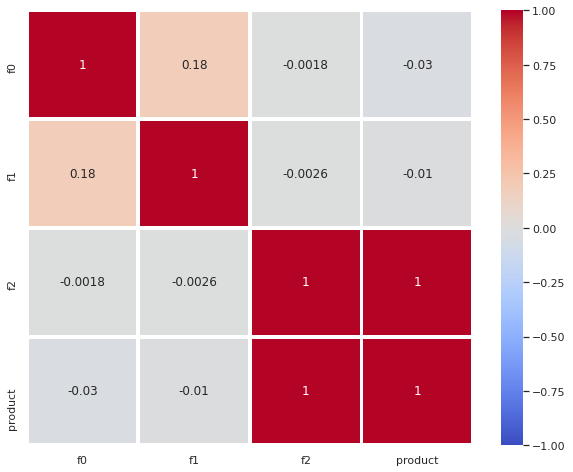

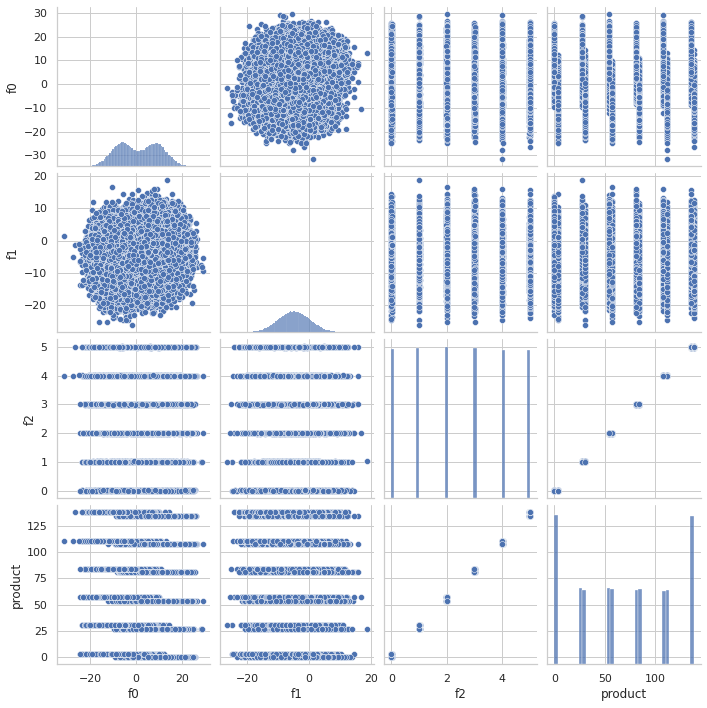

In [11]:
correlation(geo_data_1, 'id', pair_plots=True)

#### Регион 2

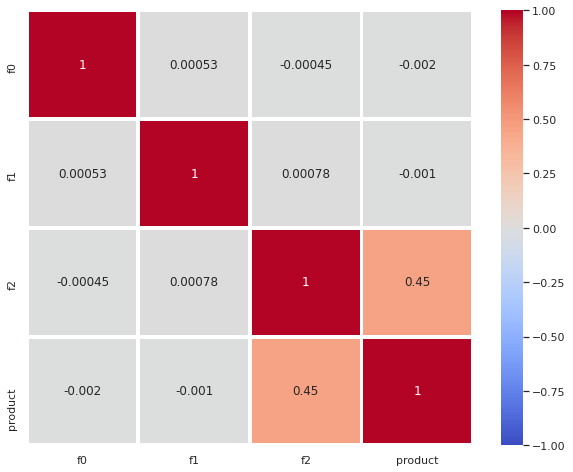

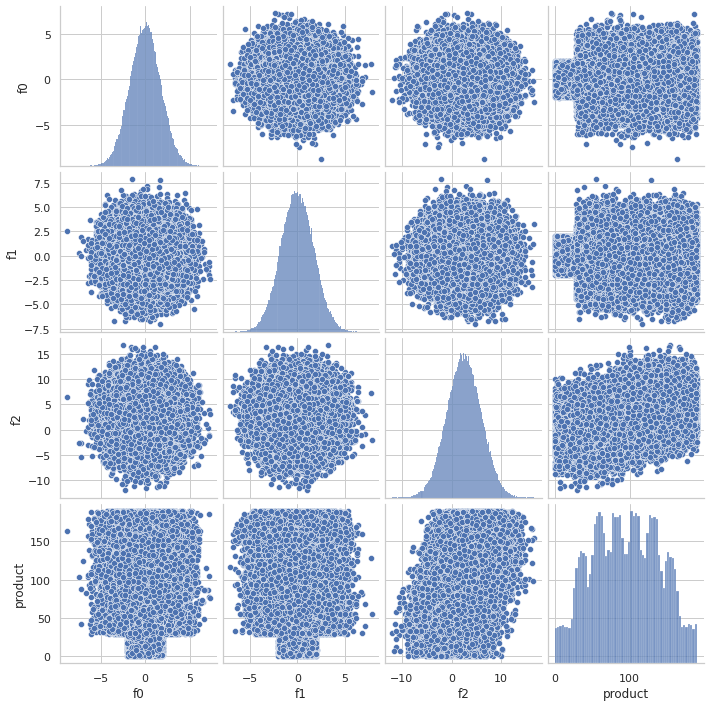

In [12]:
correlation(geo_data_2, 'id', pair_plots=True)

Сильных корреляций между независимыми параметрами не выявлено.

### Вычесление статистик

**Регион 0**

In [13]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


**Регион 1**

In [14]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


**Регион 2**

In [15]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Определение `features` и `target` для датасетов

In [16]:
features_0 = geo_data_0.drop(['product', 'id'], axis=1)
target_0 = geo_data_0['product']

features_1 = geo_data_1.drop(['product', 'id'], axis=1)
target_1 = geo_data_1['product']

features_2 = geo_data_2.drop(['product', 'id'], axis=1)
target_2 = geo_data_2['product']

### Формирование обучающих и валидационных выборок

In [17]:
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=RANDOM_STATE
)
print('geo_data_0:')
print(f'Training sample size: {X_train_0.shape[0]}')
print(f'Validation sample size: {X_val_0.shape[0]}')
print()

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=RANDOM_STATE
)
print('geo_data_1:')
print(f'Training sample size: {X_train_1.shape[0]}')
print(f'Validation sample size: {X_val_1.shape[0]}')
print()

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=RANDOM_STATE
)
print('geo_data_2:')
print(f'Training sample size: {X_train_2.shape[0]}')
print(f'Validation sample size: {X_val_2.shape[0]}')

geo_data_0:
Training sample size: 75000
Validation sample size: 25000

geo_data_1:
Training sample size: 75000
Validation sample size: 25000

geo_data_2:
Training sample size: 75000
Validation sample size: 25000


### Препроцессинг `features`

Осуществим препроцессинг следующим образом:
1. Обновим индексы для каждой выборки;
2. Стандартизируем `features` с помощью метода `MinMaxScaler`. Выбор данного метода обосновывается ненормальностью распределения параметров.

In [18]:
# Reseting indexes
X_train_0 = X_train_0.reset_index(drop=True)
y_train_0 = y_train_0.reset_index(drop=True)
X_val_0 = X_val_0.reset_index(drop=True)
y_val_0 = y_val_0.reset_index(drop=True)

X_train_1 = X_train_1.reset_index(drop=True)
y_train_1 = y_train_1.reset_index(drop=True)
X_val_1 = X_val_1.reset_index(drop=True)
y_val_1 = y_val_1.reset_index(drop=True)

X_train_2 = X_train_2.reset_index(drop=True)
y_train_2 = y_train_2.reset_index(drop=True)
X_val_2 = X_val_2.reset_index(drop=True)
y_val_2 = y_val_2.reset_index(drop=True)

# Features normalization
# region_0
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_0)
X_train_0 = pd.DataFrame(
    min_max_scaler.transform(X_train_0),
    columns=X_train_0.columns
)
X_val_0 = pd.DataFrame(
    min_max_scaler.transform(X_val_0),
    columns=X_val_0.columns
)
# region_1
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_1)
X_train_1 = pd.DataFrame(
    min_max_scaler.transform(X_train_1),
    columns=X_train_1.columns
)
X_val_1 = pd.DataFrame(
    min_max_scaler.transform(X_val_1),
    columns=X_val_1.columns
)
# region_2
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_2)
X_train_2 = pd.DataFrame(
    min_max_scaler.transform(X_train_2),
    columns=X_train_2.columns
)
X_val_2 = pd.DataFrame(
    min_max_scaler.transform(X_val_2),
    columns=X_val_2.columns
)

# Verification of results
X_train_0.sample(3), X_train_1.sample(3), X_train_2.sample(3),

(             f0        f1        f2
 19155  0.560925  0.139448  0.425906
 66271  0.854699  0.529093  0.386858
 2171   0.616328  0.713275  0.448323,
              f0        f1        f2
 43689  0.724143  0.336251  0.598895
 66664  0.621765  0.401163  0.199102
 35279  0.416313  0.541582  0.200891,
              f0        f1        f2
 6421   0.756723  0.491110  0.350888
 34421  0.511850  0.198552  0.272141
 36586  0.626535  0.501346  0.793955)

## Обучение и проверка модели

### Построение модели линейной регрессии

In [19]:
model_0 = LinearRegression()
model_0.fit(X_train_0, y_train_0)

predictions_0 = pd.Series(model_0.predict(X_val_0))
rmse_0 = mean_squared_error(y_val_0, predictions_0) ** 0.5

model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)

predictions_1 = pd.Series(model_1.predict(X_val_1))
rmse_1 = mean_squared_error(y_val_1, predictions_1) ** 0.5

model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)

predictions_2 = pd.Series(model_1.predict(X_val_2))
rmse_2 = mean_squared_error(y_val_2, predictions_2) ** 0.5

print('RMSE model_0:', rmse_0)
print('RMSE model_1:', rmse_1)
print('RMSE model_2:', rmse_2)

RMSE model_0: 37.75660035026169
RMSE model_1: 0.8902801001028844
RMSE model_2: 47.86767171086352


### Анализ предсказаний модели

**Анализ статитсик предсказаний**

In [20]:
pred_statistics(predictions_0, predictions_1, predictions_2)

Predictions statistics analysis:


,statistics,predictions_0,predictions_1,predictions_2
0,count,25000.000000,25000.000000,25000.000000
1,mean,92.398800,68.712878,69.329429
2,std,23.217563,45.946672,16.420756
3,min,-9.836371,-2.070621,5.306218
4,25%,76.788865,28.578501,58.103713
5,50%,92.414871,57.918041,69.172991
6,75%,108.036487,109.313612,80.509315
7,max,176.536104,139.983277,131.655213


**Визуализация предсказаний**

Predictions visualization:


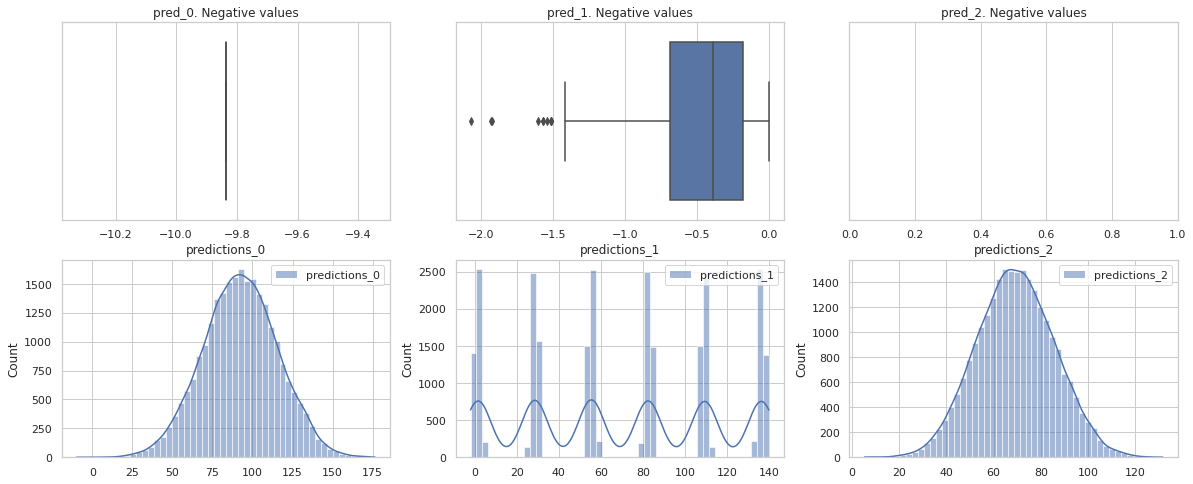

In [21]:
predictions_visualization(predictions_0, predictions_1, predictions_2, negative_values=True)

Можно увидить, что модель линейной регрессии может давать предсказания об отрицательном количестве баррелей нефти в скважине.

Поскольку такая ситация невозможна в реальном мире, необходимо заменить все отрицательные значения нулями, после чего сравнить изменение метрик.

### Корректировка предсказаний модели

**Замена отрицательных значений нулями**

In [22]:
cor_pred_0 = predictions_0
cor_pred_1 = predictions_1
cor_pred_2 = predictions_2

for i in range(len(predictions_0)):
    if predictions_0[i] < 0:
        cor_pred_0[i] = 0

for i in range(len(predictions_1)):
    if predictions_1[i] < 0:
        cor_pred_1[i] = 0

for i in range(len(predictions_2)):
    if predictions_2[i] < 0:
        cor_pred_2[i] = 0

**Повторный анализ и визуализация предсказаний**

In [23]:
pred_statistics(cor_pred_0, cor_pred_1, cor_pred_2)

Predictions statistics analysis:


,statistics,predictions_0,predictions_1,predictions_2
0,count,25000.000000,25000.000000,25000.000000
1,mean,92.399193,68.723322,69.329429
2,std,23.215913,45.930963,16.420756
3,min,0.000000,0.000000,5.306218
4,25%,76.788865,28.578501,58.103713
5,50%,92.414871,57.918041,69.172991
6,75%,108.036487,109.313612,80.509315
7,max,176.536104,139.983277,131.655213


Predictions visualization:


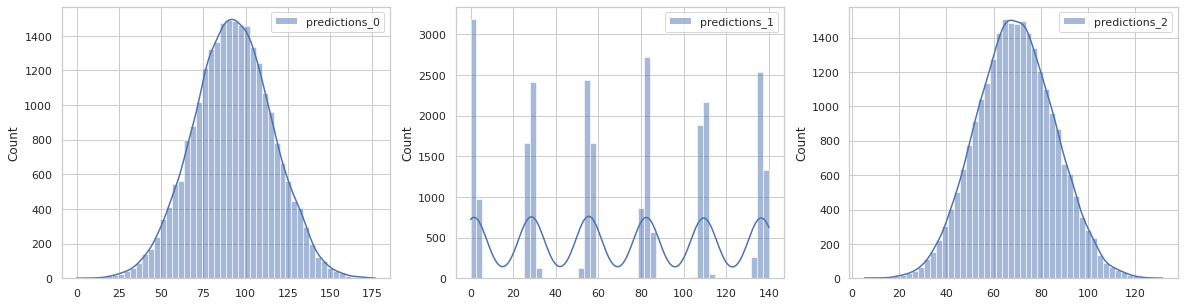

In [24]:
predictions_visualization(cor_pred_0, cor_pred_1, cor_pred_2)

### Расчет метрики RMSE

In [25]:
cor_rmse_0 = mean_squared_error(y_val_0, cor_pred_0) ** 0.5
cor_rmse_1 = mean_squared_error(y_val_1, cor_pred_1) ** 0.5
cor_rmse_2 = mean_squared_error(y_val_2, cor_pred_2) ** 0.5

rmse_table = pd.DataFrame(
    {
        'before_processing_null_values': [rmse_0, rmse_1, rmse_2],
        'after_processing_null_values': [cor_rmse_0, cor_rmse_1, cor_rmse_2],
    }
)

rmse_table

,before_processing_null_values,after_processing_null_values
0,37.756600,37.756288
1,0.890280,0.885786
2,47.867672,47.867672


Можно увидеть, что обработка отрицательных значений уменьшило ошибку моделей.

In [26]:
mean_pred_0 = cor_pred_0.mean()
mean_pred_1 = cor_pred_1.mean()
mean_pred_2 = cor_pred_2.mean()

print('Model_0:')
print('average prediction:', mean_pred_0)
print('RMSE:              ', cor_rmse_0)
print()

print('Model_1:')
print('average prediction:', mean_pred_1)
print('RMSE:              ', cor_rmse_1)
print()

print('Model_2:')
print('average prediction:', mean_pred_2)
print('RMSE:              ', cor_rmse_2)
print()

Model_0:
average prediction: 92.39919336143704
RMSE:               37.756287851323954

Model_1:
average prediction: 68.72332171961662
RMSE:               0.8857855016450422

Model_2:
average prediction: 69.32942869505288
RMSE:               47.86767171086352



По результатм оценки модели можно сделать следующие выводы:
- Можно увидеть, что наиболее точной является `Model_1` для `Региона 1`: корень из среднеквадратической ошибки составляет 0.88 тыс. баррелей, что означает, что модель дает предсказания с погрешностью в +- 0.88 тыс. баррелей.
- Модели для других регионов дают значительно большую погрешность.

Учтем это в дальнейшей работе.

### Проверка моделей на адекватность

Проверим модели на адекватность, используя `Коэффициент детерминации "R2"`

In [27]:
region_0_r2 = round(r2_score(y_val_0, cor_pred_0), 4)
region_1_r2 = round(r2_score(y_val_1, cor_pred_1), 4)
region_2_r2 = round(r2_score(y_val_2, cor_pred_2), 4)

print('R2 Score:')
print()
print('Region_0:', region_0_r2)
print('Region_1:', region_1_r2)
print('Region_2:', region_2_r2)

R2 Score:

Region_0: 0.2728
Region_1: 0.9996
Region_2: -0.1425


Проверка моделей на адекватнотсь показала:
- Предсказания модель для `Региона 2` менее эффективны, чем использование среднего значения, что, в совокупонсти с относительно высоким показателем `RMSE`, говорит об очень плохом качестве модели;
- `Модель 1` для соответствующего региона демонстрирует крайне высокую точность, близкую к единицы, что говорит о почти абсолютной точности модели.
- `Модель 0` показывает относительно слабый результат.

## Подготовка к расчёту прибыли

### Определение достаточного объёма сырья для безубыточной разработки новой скважины

In [28]:
confidence_interval_reg_0 = st.t.interval(
    0.95, len(cor_pred_0) - 1, cor_pred_0.mean(), cor_pred_0.sem()
)
confidence_interval_reg_1 = st.t.interval(
    0.95, len(cor_pred_1) - 1, cor_pred_1.mean(), cor_pred_1.sem()
)
confidence_interval_reg_2 = st.t.interval(
    0.95, len(cor_pred_2) - 1, cor_pred_2.mean(), cor_pred_2.sem()
)

print('Region_0 95% confidence interval:', confidence_interval_reg_0)
print('Region_1 95% confidence interval:', confidence_interval_reg_1)
print('Region_2 95% confidence interval:', confidence_interval_reg_2)

Region_0 95% confidence interval: (92.11139727290507, 92.68698944996902)
Region_1 95% confidence interval: (68.1539385041034, 69.29270493512985)
Region_2 95% confidence interval: (69.12586877830168, 69.53298861180409)


In [29]:
BUDGET = 10000000
UNIT_INCOME = 450

SEARCHING_WELLS = 500
DEVELOPMENT_WELLS = 200

SUFFICIENT_VOLUME = np.ceil(BUDGET / UNIT_INCOME)

average_reg_0 = target_0.mean() * DEVELOPMENT_WELLS
average_reg_1 = target_1.mean() * DEVELOPMENT_WELLS
average_reg_2 = target_2.mean() * DEVELOPMENT_WELLS

print('Budget:           ', BUDGET)
print('Unit income:      ', UNIT_INCOME)
print('Sufficient volume:', SUFFICIENT_VOLUME)
print()

print('Region sufficiency analysis:')
pd.DataFrame(
    {
        'region': ['Region_0', 'Region_1', 'Region_2'],
        'average_volume_of_200_wells': [average_reg_0, average_reg_1, average_reg_2],
        'average_revenue': round(pd.Series([average_reg_0 * UNIT_INCOME, average_reg_1 * UNIT_INCOME, average_reg_2 * UNIT_INCOME]), 2),
        'profit': round(pd.Series([average_reg_0 * UNIT_INCOME, average_reg_1 * UNIT_INCOME, average_reg_2 * UNIT_INCOME]), 2) - BUDGET,
        'is_enough': [average_reg_0 >= SUFFICIENT_VOLUME, average_reg_1 >= SUFFICIENT_VOLUME,
                      average_reg_2 >= SUFFICIENT_VOLUME],
    }
)

Budget:            10000000
Unit income:       450
Sufficient volume: 22223.0

Region sufficiency analysis:


,region,average_volume_of_200_wells,average_revenue,profit,is_enough
0,Region_0,18500.0,8325000.0,-1675000.0,False
1,Region_1,13765.0,6194250.0,-3805750.0,False
2,Region_2,19000.0,8550000.0,-1450000.0,False


Можно сделать следующие выводы:
- Средние показатели каждого региона недостаточны для получения прибыли;
- Наихудшие средние показатели у `Региона 1`.

Данный анализ обосновывает использование моделей для отбора наилучших скважин для добычи.

## Расчёт прибыли

Расчитаем потенциальную прибыль, использую технологию `Bootstrap` с 1000 выборок

In [30]:
top_200_region_0 = geo_data_0.sort_values(by='product', ascending=False).head(200)
top_200_region_1 = geo_data_1.sort_values(by='product', ascending=False).head(200)
top_200_region_2 = geo_data_2.sort_values(by='product', ascending=False).head(200)

average_reg_0 = revenue(y_val_0, predictions_0, DEVELOPMENT_WELLS)
average_reg_1 = revenue(y_val_1, predictions_1, DEVELOPMENT_WELLS)
average_reg_2 = revenue(y_val_2, predictions_2, DEVELOPMENT_WELLS)

print('Top 200 wells information:')
pd.DataFrame(
    {
        'region': ['geo_0', 'geo_1', 'geo_2'],
        'top_200_wells_reserves': round(pd.Series(
            [top_200_region_0['product'].sum(), top_200_region_1['product'].sum(), top_200_region_2['product'].sum()]),
                                        2),
        'revenue': [average_reg_0, average_reg_1, average_reg_2],
        'profit': [average_reg_0 - BUDGET, average_reg_1 - BUDGET, average_reg_2 - BUDGET],
        'roi': round(pd.Series([(average_reg_0 - BUDGET) / BUDGET * 100, (average_reg_1 - BUDGET) / BUDGET * 100, (average_reg_2 - BUDGET) / BUDGET * 100]), 2),
        'is_enough': [average_reg_0 >= BUDGET, average_reg_1 >= BUDGET, average_reg_2 >= BUDGET],
    }
)

Top 200 wells information:


,region,top_200_wells_reserves,revenue,profit,roi,is_enough
0,geo_0,36966.75,13359141.11,3359141.11,33.59,True
1,geo_1,27589.08,12415086.70,2415086.70,24.15,True
2,geo_2,37910.30,12580480.83,2580480.83,25.80,True


Расчет прибыли:
- Каждый регион демонстрирует высокую среднию прибыль;
- Наименьший `ROI` у `Региона 2`;
- Наибольший `ROI` у `Региона 0`.

## Расчет рисков

In [31]:
values_reg_0 = bootstrap_profit(1000, y_val_0, SEARCHING_WELLS, state, cor_pred_0)
lower_reg_0 = values_reg_0.quantile(0.025)
upper_reg_0 = values_reg_0.quantile(0.975)
average_reg_0 = values_reg_0.mean()
risk_reg_0 = (values_reg_0 < 0).mean() * 100

values_reg_1 = bootstrap_profit(1000, y_val_1, SEARCHING_WELLS, state, cor_pred_1)
lower_reg_1 = values_reg_1.quantile(0.025)
upper_reg_1 = values_reg_1.quantile(0.975)
average_reg_1 = values_reg_1.mean()
risk_reg_1 = (values_reg_1 < 0).mean() * 100

values_reg_2 = bootstrap_profit(1000, y_val_2, SEARCHING_WELLS, state, cor_pred_2)
lower_reg_2 = values_reg_2.quantile(0.025)
upper_reg_2 = values_reg_2.quantile(0.975)
average_reg_2 = values_reg_2.mean()
risk_reg_2 = (values_reg_2 < 0).mean() * 100

print('Region_0:')
print('Average profit: ', average_reg_0)
print('2.5% quantile:  ', lower_reg_0)
print('97.5% quantile: ', upper_reg_0)
print('Risk:           ', risk_reg_0)
print()

print('Region_1:')
print('Average profit: ', average_reg_1)
print('2.5% quantile:  ', lower_reg_1)
print('97.5% quantile: ', upper_reg_1)
print('Risk:           ', risk_reg_1)
print()

print('Region_2:')
print('Average profit: ', average_reg_2)
print('2.5% quantile:  ', lower_reg_2)
print('97.5% quantile: ', upper_reg_2)
print('Risk:           ', risk_reg_2)

Region_0:
Average profit:  427847.56054999994
2.5% quantile:   -97249.82624999934
97.5% quantile:  954215.196749999
Risk:            5.5

Region_1:
Average profit:  511530.21813
2.5% quantile:   91700.56500000009
97.5% quantile:  921455.6650000004
Risk:            0.6

Region_2:
Average profit:  400243.65997
2.5% quantile:   -126494.97349999934
97.5% quantile:  942007.7439999995
Risk:            7.3999999999999995


## Вывод

По резульатам работы, можно сказать, что наиболее оптимальным регионом является `Регион 1`:
- Потенциальная `выручка` от лучших 200 скважин 12415086.70, а `прибыль` - 2415086.70;
- Потенциальный `ROI` от лучших 200 скважин 24.15%;
- Потенциальные `2.5% квантиль прибыли` составляет 91700.57;
- Потенциальный `риск`, выраженный в прогнозируемой доли отрицательной прибыли, составляет 0.6%.

Таким образом, для бурения новых скважин рекомендуется использовать `Регион 1`.